min_samples_split은 내부 노드를 분할하는 데 필요한 최소 샘플 수를 지정하고,

min_samples_leaf는 리프 노드에 있어야하는 샘플의 최소 수를 지정한다.

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= 'Malgun Gothic')
import warnings
warnings.filterwarnings('ignore')

In [3]:
#나무 시각화 패키지 설치


## 채무 상환 데이터
상환 여부를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.

**step1. 데이터 구성하기**

In [4]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2_py/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [5]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
#JOB 변수의 결측치는 other 로 대체
df_raw['JOB'].fillna('Other', inplace = True) #fillna 함수 적용 후 df_raw 데이터에 저장 : inplace = True

#숫자형 변수의 결측치는 평균값 입력
df_raw.fillna(df_raw.mean(), inplace=True)

In [7]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [8]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [9]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['BAD']
df_raw_x = df_raw_dummy.drop('BAD',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


#### step2. 모델 생성

In [10]:
#기본옵션으로 트리생성
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set:{:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.916


In [11]:
tree_uncustomized

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [12]:
#모델 parameter 조정
#train/ test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

In [13]:
#모델 parameter 조정 : max_depth : 최대 깊이 변경에 따른 모델 성능
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.928,0.920
1,2,0.935,0.923
2,3,0.939,0.924
3,4,0.939,0.924
4,5,0.941,0.925
5,6,0.945,0.930
6,7,0.949,0.932
7,8,0.951,0.932
8,9,0.956,0.933
9,10,0.963,0.927


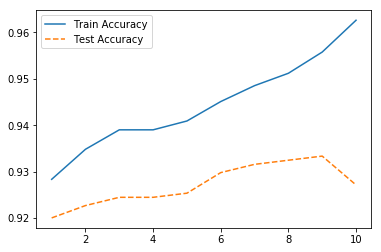

In [14]:
plt.plot(para_depth, train_accuracy, linestyle='-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle='--', label = 'Test Accuracy')
plt.legend()

최대 깊이 증가에 따라 모델의 정확도는 증가하며 train/test 데이터의 성능 변화를 고려하여 4를 선택한다.

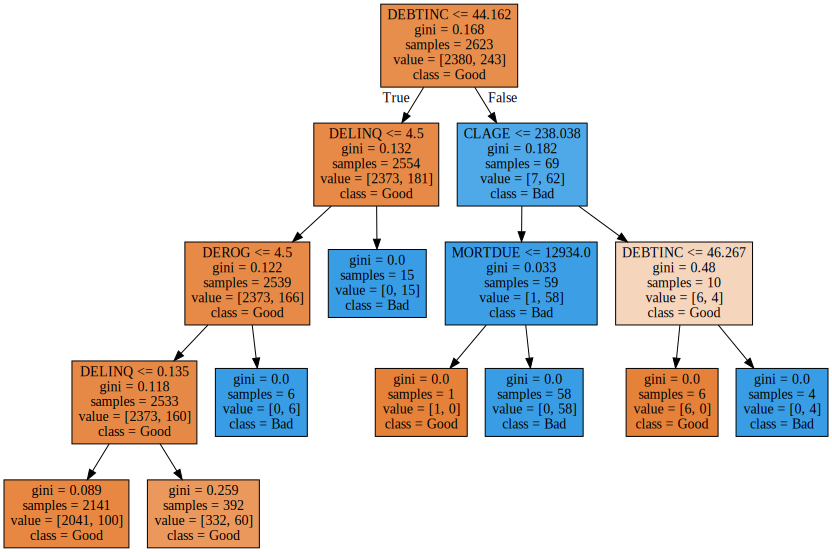

In [15]:
v_feature_name = df_train_x.columns

#길이가 4인 모델
tree_depth4 = DecisionTreeClassifier(max_depth = 4, random_state=1234)
tree_depth4.fit(df_train_x, df_train_y)

export_graphviz(tree_depth4, out_file='tree_depth4.dot', class_names=['Good','Bad'],
               feature_names=v_feature_name, impurity=True, filled=True)

with open('tree_depth4.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

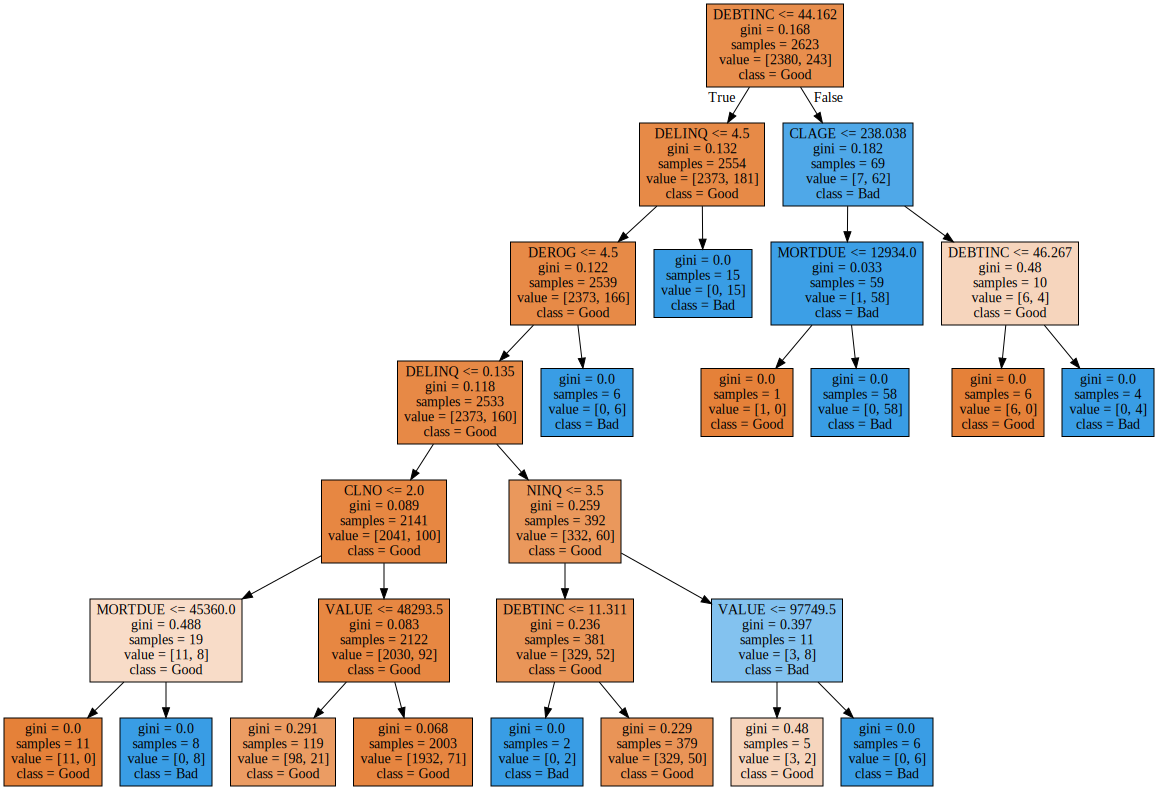

In [16]:
#길이가 6인 모델
tree_depth6 = DecisionTreeClassifier(max_depth = 6, random_state=1234)
tree_depth6.fit(df_train_x, df_train_y)

export_graphviz(tree_depth6, out_file='tree_depth6.dot', class_names=['Good','Bad'],
               feature_names=v_feature_name, impurity=True, filled=True)

with open('tree_depth6.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

깊이 6은 과대적합 !

In [17]:
#min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy = []; test_accuracy = []
para_split=[n_split * 10 for n_split in range(1,11)]
for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth = 4,
                                 random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

In [18]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.939,0.924
1,20,0.937,0.924
2,30,0.937,0.924
3,40,0.937,0.924
4,50,0.937,0.924
5,60,0.937,0.924
6,70,0.936,0.922
7,80,0.936,0.922
8,90,0.936,0.922
9,100,0.936,0.922


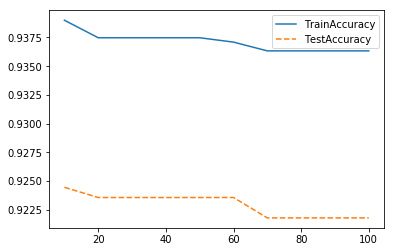

In [19]:
plt.plot(para_split, train_accuracy, linestyle='-', label='TrainAccuracy')
plt.plot(para_split, test_accuracy, linestyle='--', label='TestAccuracy')
plt.legend()

분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며 train/test 데이터의 성능 변화를 고려하여 20을 선택한다.

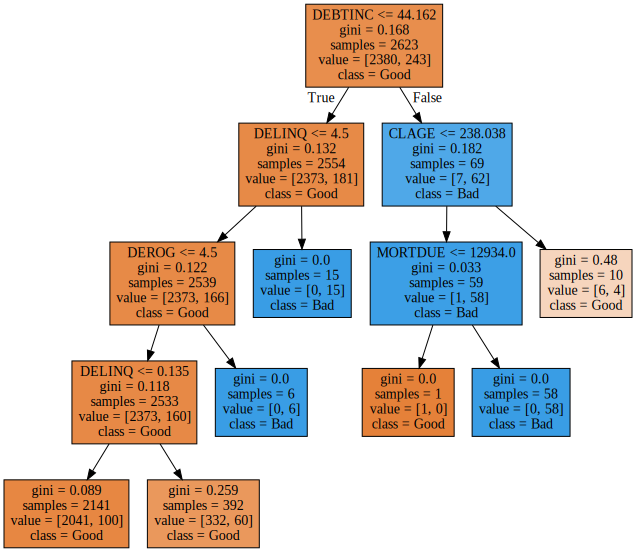

In [20]:
#min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

#분리노드의 최소 자료 수가 20인 모델
tree_depth4 = DecisionTreeClassifier(max_depth = 4, min_samples_split = 20, random_state=1234)
tree_depth4.fit(df_train_x, df_train_y)

export_graphviz(tree_depth4, out_file='tree_depth4.dot', class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity =True, filled=True)

with open('tree_depth4.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

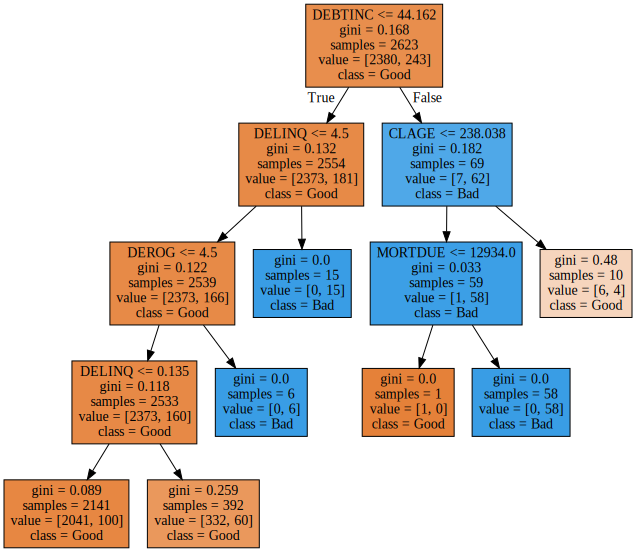

In [21]:
#분리 노드의 최소 자료 수가 30인 모델
tree_high = DecisionTreeClassifier(max_depth = 4, min_samples_split=30, random_state=1234)
tree_high.fit(df_train_x, df_train_y)

export_graphviz(tree_high, out_file='tree_high.dot', class_names=['Good', 'Bad'],
               feature_names = v_feature_name, impurity = True, filled=True)

with open('tree_high.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [31]:
#min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy = []; test_accuracy = []
para_leaf=[n_leaf * 2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split=20,
                                  max_depth = 4,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

In [32]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.937,0.924
1,4,0.937,0.924
2,6,0.937,0.924
3,8,0.937,0.924
4,10,0.937,0.924
5,12,0.937,0.924
6,14,0.934,0.921
7,16,0.933,0.918
8,18,0.933,0.918
9,20,0.933,0.918


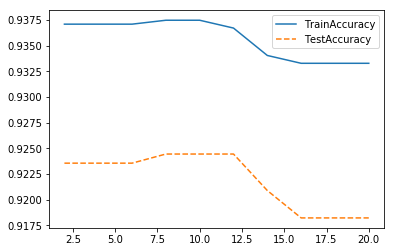

In [33]:
plt.plot(para_leaf, train_accuracy, linestyle='-', label='TrainAccuracy')
plt.plot(para_leaf, test_accuracy, linestyle='--', label='TestAccuracy')
plt.legend()

잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도는 감소하며 train/test 데이터의 성능 변화를고려하여 10을 선택한다.

분리노드 최소 자료 수를 20으로 선택했으므로 8또는 10 선택이 가능하다.

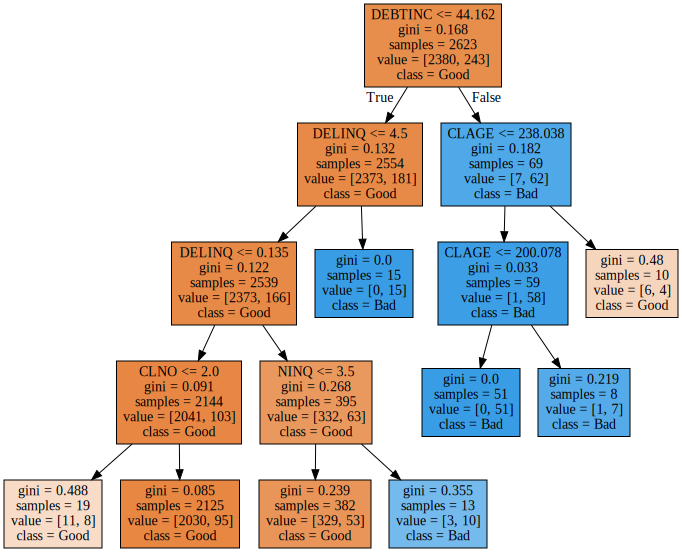

In [34]:
#잎사귀의 최소 자료 수가 8인 모델
tree_low = DecisionTreeClassifier(max_depth = 4, min_samples_split=20, min_samples_leaf=8,
                                 random_state=1234)
tree_low.fit(df_train_x, df_train_y)

export_graphviz(tree_low, out_file='tree_low.dot', class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity=True, filled=True)

with open('tree_low.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

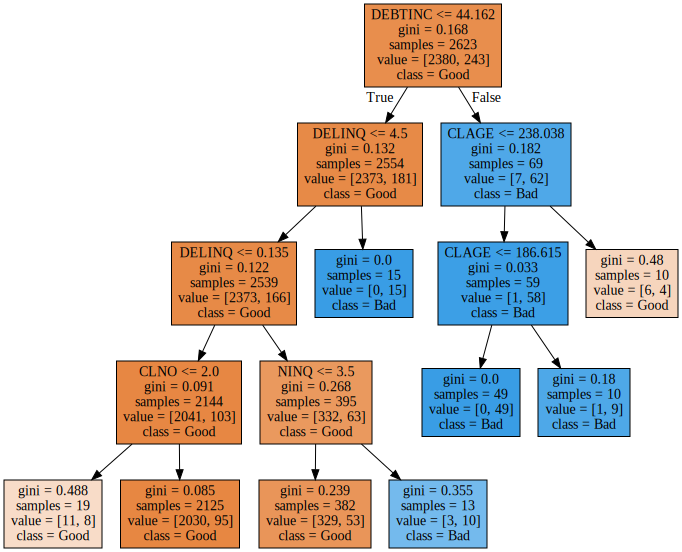

In [35]:
#잎사귀의 최소 자료 수가 10인 모델
tree_high = DecisionTreeClassifier(max_depth = 4, min_samples_split=20, min_samples_leaf=10,
                                 random_state=1234)
tree_high.fit(df_train_x, df_train_y)

export_graphviz(tree_high, out_file='tree_high.dot', class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity=True, filled=True)

with open('tree_high.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### step4. 최종 모델 선정

In [37]:
tree_final = DecisionTreeClassifier(max_depth = 4, min_samples_split=20, min_samples_leaf=8,
                                   random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

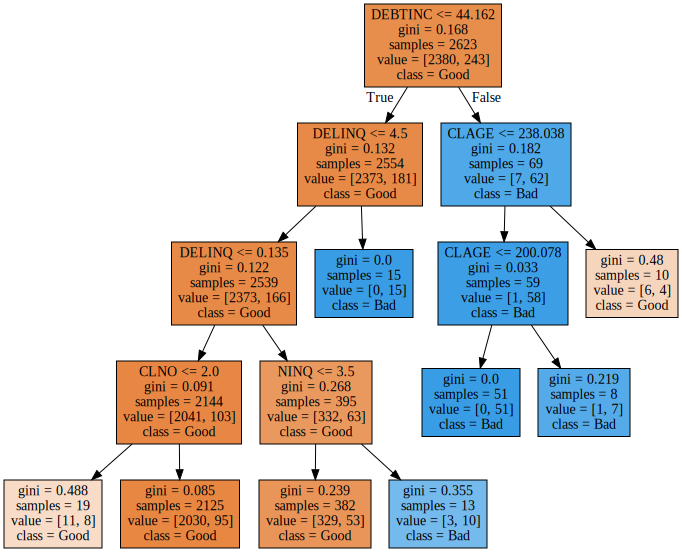

In [38]:
export_graphviz(tree_final, out_file='tree_final.dot', class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled =True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [39]:
#최종 모델 평가

y_pred = tree_final.predict(df_test_x)
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.924

Confusion matrix: 
[[1022    1]
 [  84   18]]


In [40]:
#결론도출
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.623
5,DELINQ,0.232
7,NINQ,0.068
6,CLAGE,0.041
8,CLNO,0.036
11,REASON_HomeImp,0.000
16,JOB_Sales,0.000
15,JOB_ProfExe,0.000
14,JOB_Other,0.000
13,JOB_Office,0.000


Text(0, 0.5, '설명변수')

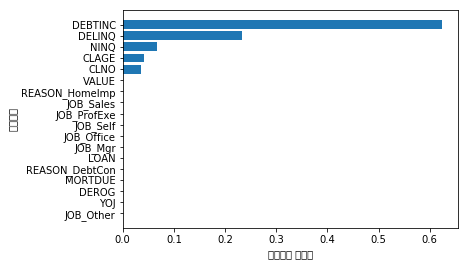

In [41]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

부채비율(DEBTINC), 연체된 신용 한도의 수(DELINQ) 순으로 영향이 크다고 해석할 수 있음

In [42]:
#GridSearchCV를 이용한 최적 parameter 찾기

estimator = DecisionTreeClassifier()

param_grid = {'max_depth': para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model:\n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score:\n{}'.format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

best parameter:
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}

best score:
0.934


## 채무 상환 데이터
상환 여부를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.

**step1. 데이터 구성하기**

In [56]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2_py/통신고객이탈.csv")
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [57]:
df_raw.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

결측치는 없다.

In [58]:
#명목형 변수 목록
obj_cols = df_raw.select_dtypes('object').columns
for col in obj_cols :
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

CHURN : 2
CUSTOMER_ID : 930
GENDER : 2
CHARGE_TYPE : 5
HANDSET : 11
USAGE_BAND : 6


In [59]:
df_raw['CHURN'] = np.where(df_raw['CHURN'] == 'Active',0,1)
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [60]:
df_raw['CHURN'].value_counts()

0    750
1    180
Name: CHURN, dtype: int64

In [61]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,0,31,33.33,6,218,379.8,9,21.6,366,632.4,...,0,0,0,0,0,0,1,0,0,0
1,0,27,30.87,10,373,656.4,11,28.0,411,810.4,...,0,0,0,0,0,0,1,0,0,0
2,0,27,49.40,11,260,582.0,0,0.0,265,614.1,...,0,0,0,0,0,0,1,0,0,0
3,0,61,48.60,1,294,661.8,14,101.5,326,844.0,...,0,0,0,0,0,0,1,0,0,0
4,0,52,56.03,0,221,555.6,7,25.0,274,673.0,...,0,0,0,0,0,0,1,0,0,0


In [62]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['CHURN']
df_raw_x = df_raw_dummy.drop('CHURN',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (651, 963)
train data Y size : (651,)
test data X size : (279, 963)
test data Y size : (279,)
